In [1]:
%matplotlib inline
# disable autoreload for global dataset
%load_ext autoreload
%autoreload 2

In [2]:
from learn import *

In [3]:
num_gpus = 2
gpu_start = 8
num_workers = 3 * num_gpus
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

bs = 15

## Plot predictions

In [4]:
model_name = 'deeplab'

In [5]:
data = None

In [6]:
#resume
learn, denorm, data = learner_on_dataset(datapaths[2], bs, device_ids, num_workers, model_name=model_name,
                                         debug=False, global_dataset=False, data=data, num_slice=9, sz=256)
(trn_x,trn_y), (val_x,val_y) = data


Data finished loading: data/train/AOI_4_Shanghai_Train


## plots

In [7]:
learn.load('deeplab-shanghai-wds')

In [8]:
%%time
preds = learn.predict()

CPU times: user 2h 46min 42s, sys: 13min 55s, total: 3h 37s
Wall time: 5min 20s


In [9]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))

CPU times: user 3min, sys: 29.7 s, total: 3min 30s
Wall time: 15.7 s


In [10]:
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]

In [18]:
preds[10]

array([[-3.79586, -3.76775, -3.73964, ..., -3.54549, -3.54927, -3.55306],
       [-3.76624, -3.7362 , -3.70615, ..., -3.50309, -3.50242, -3.50175],
       [-3.73662, -3.70465, -3.67267, ..., -3.46069, -3.45556, -3.45043],
       ...,
       [-3.61338, -3.59935, -3.58533, ..., -0.45257, -0.43985, -0.42714],
       [-3.60582, -3.58952, -3.57321, ..., -0.46064, -0.44504, -0.42945],
       [-3.59826, -3.57968, -3.56109, ..., -0.4687 , -0.45023, -0.43176]], dtype=float32)

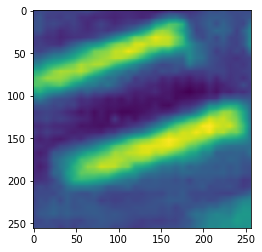

In [20]:
plt.imshow(preds[10])

In [12]:
thresh = np.linspace(0, 2, 50)

In [13]:
score = [F.binary_cross_entropy_with_logits(T(preds).cpu(), T(bool_pred(y, t).astype('float')).cpu()) for t in thresh]

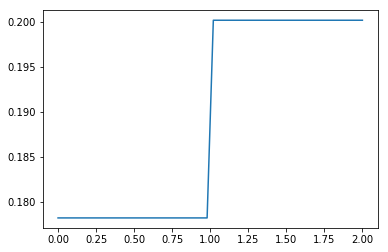

In [14]:
plt.plot(thresh, score)

In [ ]:
scores = None

In [ ]:
scores = plot_worse_preds(x, y, preds, learn, F.binary_cross_entropy_with_logits, shift=10,
                          scores=scores, is_best=True, thresh=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## CRF

In [86]:
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle

from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger


data_train = pickle.load(open("data_train_dict.pickle"))
C = 0.01

n_states = 21
print("number of samples: %s" % len(data_train['X']))
class_weights = 1. / np.bincount(np.hstack(data_train['Y']))
class_weights *= 21. / np.sum(class_weights)
print(class_weights)

model = crfs.EdgeFeatureGraphCRF(inference_method='qpbo',
                                 class_weight=class_weights,
                                 symmetric_edge_features=[0, 1],
                                 antisymmetric_edge_features=[2])

experiment_name = "edge_features_one_slack_trainval_%f" % C

ssvm = learners.NSlackSSVM(
    model, verbose=2, C=C, max_iter=100000, n_jobs=-1,
    tol=0.0001, show_loss_every=5,
    logger=SaveLogger(experiment_name + ".pickle", save_every=100),
    inactive_threshold=1e-3, inactive_window=10, batch_size=100)
ssvm.fit(data_train['X'], data_train['Y'])

data_val = pickle.load(open("data_val_dict.pickle"))
y_pred = ssvm.predict(data_val['X'])

# we throw away void superpixels and flatten everything
y_pred, y_true = np.hstack(y_pred), np.hstack(data_val['Y'])
y_pred = y_pred[y_true != 255]
y_true = y_true[y_true != 255]

print("Score on validation set: %f" % np.mean(y_true == y_pred))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte